In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

%matplotlib inline

In [2]:
df = pd.read_csv('sentiment labelled sentences/yelp_labelled.txt', delimiter='\t', header=None)

df.columns = ['review', 'score']
df['review'] = df['review'].str.lower()
df['review'] = df['review'].str.replace('.', ' ')
df['review'] = df['review'].str.replace(',', ' ')
df['review'] = df['review'].str.replace('!', ' ')

#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df['score'] = (df['score'] == 0)

In [3]:
np.sum(df['score']==True)/np.sum(df['score']==False)

1.0

This indicates that there is no class imbalace since there are an equal number of good and bad reviews and there is not a significant difference between one or the other. 

In [16]:
len(df)

1000

In [5]:
bad = np.where(df['score'] == True)

In [6]:
#chose these keywords based off of words that you might find most likely to be in a bad yelp review
keywords = ['bad', 'nasty', 'horrible', 'terrible', 
            'not', 'never', 'long', 'no', "didn't", 
            "wouldn't",'slow', 'disgusted', 'worst', 
            'poor', 'mess', 'underwhelming', 'disappointed',
            'wait', 'rude', 'horrible', 'mediocre', 'nothing']

for key in keywords:
    df[str(key)] = df.review.str.contains(str(key), case=False)

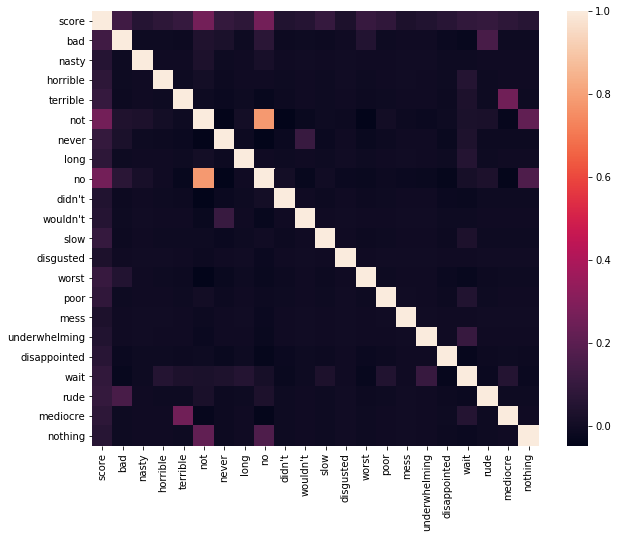

In [7]:
#making sure that my features are relatively independent of eachother.
plt.figure(figsize = (10,8))
sns.heatmap(df.corr())

plt.show()

In [8]:
#training data
data = df[keywords]
target = df['score']

In [15]:
#since the data is binary, import Bernoulli class
from sklearn.naive_bayes import BernoulliNB

#instantiate our model and store it in a new variable
bnb = BernoulliNB()

#fit model to data
bnb.fit(data, target)

#classify, storing the result in a new variable
y_pred = bnb.predict(data)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data.shape[0], (target != y_pred).sum()))

print('{}% mislabeled'.format((target != y_pred).sum()/data.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data.shape[0], 
    (target == y_pred).sum()
))

print('Accuracy = {:.4}%'.format((target == y_pred).sum()/data.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target, y_pred)
false_pos = mat[1][0]
false_neg = mat[0][1]
specificity = mat[0][0]/sum(mat[0])
sensitivity = mat[1][1]/sum(mat[1])

print('confustion matrix: \n {}'.format(mat))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('specificity: {:.4}%'.format(specificity*100))
print('sensitivity: {:.4}%'.format(sensitivity*100))

Number of mislabeled points out of a total 1000 points : 299
29.9% mislabeled
Number of correctly identified points out of a total 1000 points : 701
Accuracy = 70.1%
confustion matrix: 
 [[434  66]
 [233 267]]
false positives: 233
false negatives: 66
specificity: 86.8%
sensitivity: 53.4%


In [17]:
from sklearn.model_selection import cross_val_score
cross_validation = cross_val_score(bnb, data, target, cv=3)

print(cross_validation)
print('mean: {}%'.format(np.mean(cross_validation)*100))
print('standard deviation: {}%'.format(np.std(cross_validation)*100))

[0.7005988  0.68862275 0.69578313]
mean: 69.50015631387826%
standard deviation: 0.4920336633875107%


In [11]:
# Implement your own cross validation with your spam model.
def cross_validation(fit, data, target, k):
    from sklearn.metrics import confusion_matrix

    #fit = bnb
    #k = number of folds - must be a value that allows equal split
    
    rand_data = data.sample(frac=1)
    n_data = np.split(rand_data, indices_or_sections=k)
    
    vals = []
    matrices = []
    
    for i in range(len(n_data)):
        index = n_data[i].index
        
        test_data = data.drop(index, axis=0)
        test_target = target.drop(index, axis=0)
        vals.append(bnb.fit(test_data, test_target).score(n_data[i], target[index]))
        
        y_pred = bnb.predict(n_data[i])
        matrices.append(confusion_matrix(target[index], y_pred))
        
    return vals, matrices

In [12]:
k = 10
cross_val = cross_validation(bnb, data, target, k)

print(cross_val[0])
print('mean: {}%'.format(np.mean(cross_val[0])*100))
print('standard deviation: {}%'.format(np.std(cross_val[0])*100))

for i in range(k):
    mat = cross_val[1][i]
    false_pos = mat[1][0]
    false_neg = mat[0][1]
    specificity = mat[0][0]/sum(mat[0])
    sensitivity = mat[1][1]/sum(mat[1])
    
    print('k = {}'.format(i))
    print('accuracy: {}%'.format(cross_val[0][i]*100))
    print('confustion matrix: \n {}'.format(mat))
    print('false positives: {}'.format(false_pos))
    print('false negatives: {}'.format(false_neg))
    print('sensitivity: {:.4}%'.format(sensitivity*100))
    print('specificity: {:.4}%'.format(specificity*100))
    print('\n')

[0.65, 0.71, 0.72, 0.71, 0.69, 0.68, 0.69, 0.67, 0.7, 0.66]
mean: 68.8%
standard deviation: 2.1817424229271403%
k = 0
accuracy: 65.0%
confustion matrix: 
 [[46  9]
 [26 19]]
false positives: 26
false negatives: 9
sensitivity: 42.22%
specificity: 83.64%


k = 1
accuracy: 71.0%
confustion matrix: 
 [[37  7]
 [22 34]]
false positives: 22
false negatives: 7
sensitivity: 60.71%
specificity: 84.09%


k = 2
accuracy: 72.0%
confustion matrix: 
 [[46  9]
 [19 26]]
false positives: 19
false negatives: 9
sensitivity: 57.78%
specificity: 83.64%


k = 3
accuracy: 71.0%
confustion matrix: 
 [[43  2]
 [27 28]]
false positives: 27
false negatives: 2
sensitivity: 50.91%
specificity: 95.56%


k = 4
accuracy: 69.0%
confustion matrix: 
 [[45  6]
 [25 24]]
false positives: 25
false negatives: 6
sensitivity: 48.98%
specificity: 88.24%


k = 5
accuracy: 68.0%
confustion matrix: 
 [[40  6]
 [26 28]]
false positives: 26
false negatives: 6
sensitivity: 51.85%
specificity: 86.96%


k = 6
accuracy: 69.0%
confusti

# Testing the other data - IMDB

In [13]:
df1 = pd.read_csv('sentiment labelled sentences/imdb_labelled.txt', delimiter='\t', header=None)

df1.columns = ['review', 'score']
df1['review'] = df1['review'].str.lower()
#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df1['score'] = (df1['score'] == 0)


for key in keywords:
    df1[str(key)] = df1.review.str.contains('' + str(key) + ' ', case=False)

data1 = df1[keywords]   
target1 = df1['score']  
    
#classify, storing the result in a new variable
y_pred1 = bnb.predict(data1)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data1.shape[0], (target1 != y_pred1).sum()))

print('{}% mislabeled'.format((target1 != y_pred1).sum()/data1.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data1.shape[0], 
    (target1 == y_pred1).sum()
))

print('Accuracy = {:.4}%'.format((target1 == y_pred1).sum()/data1.shape[0]*100))

from sklearn.metrics import confusion_matrix
mat1 = confusion_matrix(target1, y_pred1)
false_pos = mat1[1][0]
false_neg = mat1[0][1]
specificity = mat1[0][0]/sum(mat1[0])
sensitivity = mat1[1][1]/sum(mat1[1])

print('confustion matrix: \n {}'.format(mat1))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 748 points : 284
37.967914438502675% mislabeled
Number of correctly identified points out of a total 748 points : 464
Accuracy = 62.03%
confustion matrix: 
 [[348  38]
 [246 116]]
false positives: 246
false negatives: 38
sensitivity: 32.04%
specificity: 90.16%


# Amazon

In [14]:
df2 = pd.read_csv('sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)

df2.columns = ['review', 'score']
df2['review'] = df2['review'].str.lower()
#score - bad is 0, good is 1

#turning score column into boolean - where True is BAD.
#Don't run this column more than once!!! otherwise everything False
df2['score'] = (df2['score'] == 0)

#chose these keywords based off of words that you might find most likely to be in a bad yelp review

for key in keywords:
    df2[str(key)] = df2.review.str.contains('' + str(key) + ' ', case=False)

data2 = df2[keywords]   
target2 = df2['score']  
    
#classify, storing the result in a new variable
y_pred2 = bnb.predict(data2)

#displaying results
print('Number of mislabeled points out of a total {} points : {}'.format(data1.shape[0], (target2 != y_pred2).sum()))

print('{}% mislabeled'.format((target2 != y_pred2).sum()/data2.shape[0]*100))

# Calculate the accuracy of your model here.
print('Number of correctly identified points out of a total {} points : {}'.format(
    data2.shape[0], 
    (target2 == y_pred2).sum()
))

print('Accuracy = {:.4}%'.format((target2 == y_pred2).sum()/data2.shape[0]*100))


from sklearn.metrics import confusion_matrix
mat2 = confusion_matrix(target2, y_pred2)
false_pos = mat2[1][0]
false_neg = mat2[0][1]
specificity = mat2[0][0]/sum(mat2[0])
sensitivity = mat2[1][1]/sum(mat2[1])

print('confustion matrix: \n {}'.format(mat2))
print('false positives: {}'.format(false_pos))
print('false negatives: {}'.format(false_neg))
print('sensitivity: {:.4}%'.format(sensitivity*100))
print('specificity: {:.4}%'.format(specificity*100))

Number of mislabeled points out of a total 748 points : 368
36.8% mislabeled
Number of correctly identified points out of a total 1000 points : 632
Accuracy = 63.2%
confustion matrix: 
 [[468  32]
 [336 164]]
false positives: 336
false negatives: 32
sensitivity: 32.8%
specificity: 93.6%
